In [1]:
# Import libraries
import numpy as np
import pandas as pd
import scipy
from scipy import special
from pathlib import Path
import matplotlib.pyplot as plt
import math
import scipy.stats as scs

In [2]:
Nout = 100000  # number of out-of-sample scenarios
Nin = 5000     # number of in-sample scenarios
Ns = 5         # number of idiosyncratic scenarios for each systemic

C = 8          # number of credit states

# Read and parse instrument data
instr_data = np.array(pd.read_csv('instrum_data.csv', header=None))
instr_id = instr_data[:, 0]     # ID
driver = instr_data[:, 1]       # credit driver
beta = instr_data[:, 2]         # beta (sensitivity to credit driver)
recov_rate = instr_data[:, 3]   # expected recovery rate
value = instr_data[:, 4]        # value
prob = instr_data[:, 5:(5 + C)] # credit-state migration probabilities (default to AAA)
exposure = instr_data[:, 5 + C:5 + 2 * C]  # credit-state migration exposures (default to AAA)
retn = instr_data[:, 5 + 2 * C] # market returns

K = instr_data.shape[0]         # number of CPs

# Read matrix of correlations for credit drivers
rho = np.array(pd.read_csv('credit_driver_corr.csv', sep='\t', header=None))
# Cholesky decomp of rho (for generating correlated Normal random numbers)
sqrt_rho = np.linalg.cholesky(rho)

print('======= Credit Risk Model with Credit-State Migrations =======')
print('============== Monte Carlo Scenario Generation ===============')
print(' ')
print(' ')
print(' Number of out-of-sample Monte Carlo scenarios = ' + str(Nout))
print(' Number of in-sample Monte Carlo scenarios = ' + str(Nin))
print(' Number of counterparties = ' + str(K))
print(' ')

======= Credit Risk Model with Credit-State Migrations =======
============== Monte Carlo Scenario Generation ===============
 
 
 Number of out-of-sample Monte Carlo scenarios = 100000
 Number of in-sample Monte Carlo scenarios = 5000
 Number of counterparties = 100
 


In [3]:
# Find credit-state for each counterparty
# 8 = AAA, 7 = AA, 6 = A, 5 = BBB, 4 = BB, 3 = B, 2 = CCC, 1 = default
CS = np.argmax(prob, axis=1) + 1

# Account for default recoveries
exposure[:, 0] = (1 - recov_rate) * exposure[:, 0]

# Compute credit-state boundaries
CS_Bdry = scipy.special.ndtri((np.cumsum(prob[:, 0:C - 1], 1)))

Losses_out = np.zeros((Nout,100))
sigma = np.sqrt(1 - beta**2)
for s in range(Nout):
    y = np.dot(np.random.randn(50),sqrt_rho) #Correlated random numbers
    z = np.random.randn(1) #Specific Risk
    yjk = [y[i-1] for i in driver.astype(int)] #Systemic risk

    w = beta*yjk + sigma*z #Calculation of W

    for i in range(len(w)):
        if w[i]>=CS_Bdry[i][6]:
            Losses_out[s,i] = exposure[i][7] #Assigning losses according to the W values for each asset
        elif w[i]>=CS_Bdry[i][5]:
            Losses_out[s,i] = exposure[i][6] #Assigning losses according to the W values for each asset
        elif w[i]>=CS_Bdry[i][4]:
            Losses_out[s,i] = exposure[i][5] #Assigning losses according to the W values for each asset
        elif w[i]>=CS_Bdry[i][3]:
            Losses_out[s,i] = exposure[i][4] #Assigning losses according to the W values for each asset
        elif w[i]>=CS_Bdry[i][2]:
            Losses_out[s,i] = exposure[i][3] #Assigning losses according to the W values for each asset
        elif w[i]>=CS_Bdry[i][1]:
            Losses_out[s,i] = exposure[i][2] #Assigning losses according to the W values for each asset
        elif w[i]>=CS_Bdry[i][0]:
            Losses_out[s,i] = exposure[i][1] #Assigning losses according to the W values for each asset
        else:
            Losses_out[s,i] = exposure[i][0] #Assigning losses according to the W values for each asset

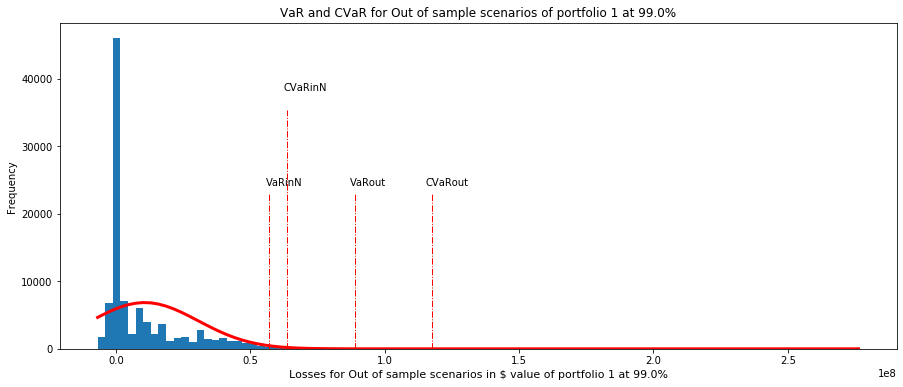

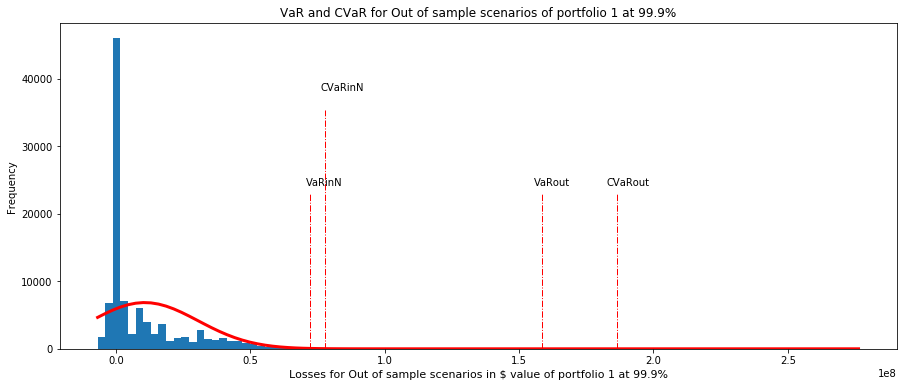

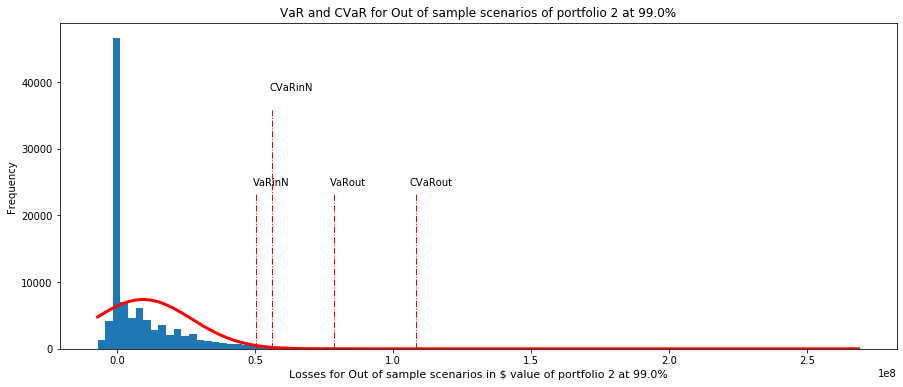

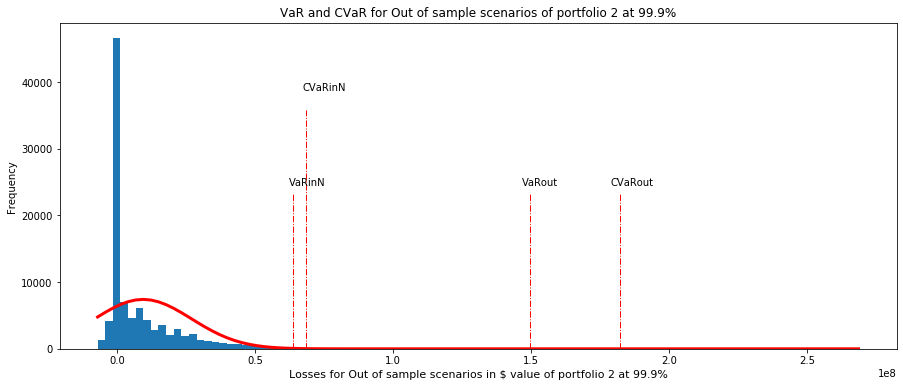

In [4]:
# Normal approximation computed from out-of-sample scenarios
mu_l = np.mean(Losses_out, axis=0).reshape((K))
var_l = np.cov(Losses_out, rowvar=False)

# Compute portfolio weights
portf_v = sum(value)  # portfolio value
w0 = []
w0.append(value / portf_v)   # asset weights (portfolio 1)
w0.append(np.ones((K)) / K)  # asset weights (portfolio 2)
x0 = []
x0.append((portf_v / value) * w0[0])  # asset units (portfolio 1)
x0.append((portf_v / value) * w0[1])  # asset units (portfolio 2)

# Quantile levels (99%, 99.9%)
alphas = np.array([0.99, 0.999])

VaRout = np.zeros((2, alphas.size))
VaRinN = np.zeros((2, alphas.size))
CVaRout = np.zeros((2, alphas.size))
CVaRinN = np.zeros((2, alphas.size))
PL = np.zeros((Nout, len(x0)))
for portN in range(2):
    # Compute VaR and CVaR
    for q in range(alphas.size):
        alf = alphas[q]
        
        PL[:,portN] = np.sort(np.dot(Losses_out, x0[portN]))
        
        VaRout[portN, q] = PL[:,portN][int(math.ceil(Nout * alphas[q])) - 1]
        VaRinN[portN, q] = np.mean(PL[:,portN]) + scs.norm.ppf(alphas[q]) * np.std(PL[:,portN])
        CVaRout[portN, q] = (1 / (Nout * (1 - alphas[q]))) * ((math.ceil(Nout * alphas[q]) - Nout * alphas[q]) * VaRout[portN, q] + sum(PL[:,portN][int(math.ceil(Nout * alphas[q])):]))
        CVaRinN[portN, q] = np.mean(PL[:,portN]) + (scs.norm.pdf(scs.norm.ppf(alphas[q])) / (1 - alphas[q])) * np.std(PL[:,portN])
        
        #Plot of VaR and CvaR with respect to portfolio and alphas
        plt.figure(figsize = (15,6))
        frequencyCounts, binLocations, patches = plt.hist(PL[:,portN], 100)
        normf = (1 / (np.std(PL[:,portN]) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations - np.mean(PL[:,portN])) / np.std(PL[:,portN])) ** 2)
        normf = normf * sum(frequencyCounts) / sum(normf)
        plt.plot(binLocations, normf, color='r', linewidth=3.0)
        plt.plot([VaRinN[portN, q], VaRinN[portN, q]], [0, max(frequencyCounts) / 2], color='r', linewidth=1, linestyle='-.')
        plt.plot([VaRout[portN, q], VaRout[portN, q]], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
        plt.plot([CVaRinN[portN, q], CVaRinN[portN, q]], [0, max(frequencyCounts) / 1.3], color='r', linewidth=1, linestyle='-.')
        plt.plot([CVaRout[portN, q], CVaRout[portN, q]], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
        plt.text(0.98 * VaRout[portN, q], max(frequencyCounts) / 1.9, 'VaRout')
        plt.text(0.98 * VaRinN[portN, q], max(frequencyCounts) / 1.9, 'VaRinN')
        plt.text(0.98 * CVaRout[portN, q], max(frequencyCounts) / 1.9, 'CVaRout')
        plt.text(0.98 * CVaRinN[portN, q], max(frequencyCounts) / 1.2, 'CVaRinN')
        plt.title('VaR and CVaR for Out of sample scenarios of portfolio '+str(portN+1)+' at '+str(100*alf)+'%')
        plt.xlabel('Losses for Out of sample scenarios in $ value of portfolio '+str(portN+1)+' at '+str(100*alf)+'%', fontsize = 11)
        plt.ylabel('Frequency')
        plt.show()

In [5]:
# Perform 100 trials
N_trials = 100

VaRinMC1 = {}
VaRinMC2 = {}
VaRinN1 = {}
VaRinN2 = {}
CVaRinMC1 = {}
CVaRinMC2 = {}
CVaRinN1 = {}
CVaRinN2 = {}

for portN in range(2):
    for q in range(alphas.size):
        VaRinMC1[portN, q] = np.zeros(N_trials)
        VaRinMC2[portN, q] = np.zeros(N_trials)
        VaRinN1[portN, q] = np.zeros(N_trials)
        VaRinN2[portN, q] = np.zeros(N_trials)
        CVaRinMC1[portN, q] = np.zeros(N_trials)
        CVaRinMC2[portN, q] = np.zeros(N_trials)
        CVaRinN1[portN, q] = np.zeros(N_trials)
        CVaRinN2[portN, q] = np.zeros(N_trials)

In [6]:
Losses_in1 = [] #Losses in MC1 with 100 trials
Losses_in2 = [] #Losses in MC2 with 100 trials
portf_loss_in1 = [] #Portfolio losses in MC1 with 100 trials
portf_loss_in2 = [] #Portfolio losses in MC2 with 100 trials
for tr in range(N_trials):
    # Monte Carlo approximation 1

    Losses_inMC1 = np.zeros((Nin, K)) #Losses in MC1

    for s in range(np.int(np.ceil(Nin / Ns))): # systemic scenarios

        y = np.dot(np.random.randn(50),sqrt_rho) #Correlated random numbers
        yjk = [y[i-1] for i in driver.astype(int)] #Systemic Risk
        
        for si in range(Ns): # idiosyncratic scenarios for each systemic
            
            z = np.random.randn(1) #Specific Risk
            w = beta*yjk + sigma*z #Calculation of W
            
            for i in range(len(w)):
                if w[i]>=CS_Bdry[i][6]:
                    Losses_inMC1[5*s+si,i] = exposure[i][7] #Assigning losses according to the W values for each asset
                elif w[i]>=CS_Bdry[i][5]:
                    Losses_inMC1[5*s+si,i] = exposure[i][6] #Assigning losses according to the W values for each asset
                elif w[i]>=CS_Bdry[i][4]:
                    Losses_inMC1[5*s+si,i] = exposure[i][5] #Assigning losses according to the W values for each asset
                elif w[i]>=CS_Bdry[i][3]:
                    Losses_inMC1[5*s+si,i] = exposure[i][4] #Assigning losses according to the W values for each asset
                elif w[i]>=CS_Bdry[i][2]:
                    Losses_inMC1[5*s+si,i] = exposure[i][3] #Assigning losses according to the W values for each asset
                elif w[i]>=CS_Bdry[i][1]:
                    Losses_inMC1[5*s+si,i] = exposure[i][2] #Assigning losses according to the W values for each asset
                elif w[i]>=CS_Bdry[i][0]:
                    Losses_inMC1[5*s+si,i] = exposure[i][1] #Assigning losses according to the W values for each asset
                else:
                    Losses_inMC1[5*s+si,i] = exposure[i][0] #Assigning losses according to the W values for each asset

    # Calculate losses for MC1 approximation (5000 x 100)
    Losses_in1.append(Losses_inMC1)


    # Monte Carlo approximation 2

    Losses_inMC2 = np.zeros((Nin, K)) #Losses in MC2
    for s in range(Nin): # systemic scenarios (1 idiosyncratic scenario for each systemic)
        
        y = np.dot(np.random.randn(50),sqrt_rho) #Correlated random numbers
        yjk = [y[i-1] for i in driver.astype(int)] #Systemic Risk
        z = np.random.randn(1) #Specific Risk
        w = beta*yjk + sigma*z #Calculation of W
        
        for i in range(len(w)):
            if w[i]>=CS_Bdry[i][6]:
                Losses_inMC2[s,i] = exposure[i][7] #Assigning losses according to the W values for each asset
            elif w[i]>=CS_Bdry[i][5]:
                Losses_inMC2[s,i] = exposure[i][6] #Assigning losses according to the W values for each asset
            elif w[i]>=CS_Bdry[i][4]:
                Losses_inMC2[s,i] = exposure[i][5] #Assigning losses according to the W values for each asset
            elif w[i]>=CS_Bdry[i][3]:
                Losses_inMC2[s,i] = exposure[i][4] #Assigning losses according to the W values for each asset
            elif w[i]>=CS_Bdry[i][2]:
                Losses_inMC2[s,i] = exposure[i][3] #Assigning losses according to the W values for each asset
            elif w[i]>=CS_Bdry[i][1]:
                Losses_inMC2[s,i] = exposure[i][2] #Assigning losses according to the W values for each asset
            elif w[i]>=CS_Bdry[i][0]:
                Losses_inMC2[s,i] = exposure[i][1] #Assigning losses according to the W values for each asset
            else:
                Losses_inMC2[s,i] = exposure[i][0] #Assigning losses according to the W values for each asset

#     Calculated losses for MC2 approximation (5000 x 100)
    Losses_in2.append(Losses_inMC2)


    # Compute VaR and CVaR

    for portN in range(2):
        for q in range(alphas.size):
            alf = alphas[q]
        
            # Compute portfolio loss
            portf_loss_inMC1 = np.sort(np.dot(Losses_inMC1, x0[portN]))
            portf_loss_inMC2 = np.sort(np.dot(Losses_inMC2, x0[portN]))
            mu_MC1 = np.mean(Losses_inMC1, axis=0).reshape((K))
            var_MC1 = np.cov(Losses_inMC1, rowvar=False)
            mu_MC2 = np.mean(Losses_inMC2, axis=0).reshape((K))
            var_MC2 = np.cov(Losses_inMC2, rowvar=False)
            # Compute portfolio mean loss mu_p_MC1 and portfolio standard deviation of losses sigma_p_MC1
            # Compute portfolio mean loss mu_p_MC2 and portfolio standard deviation of losses sigma_p_MC2
            # Compute VaR and CVaR for the current trial
            mu_p_MC1 = np.mean(portf_loss_inMC1)
            sigma_p_MC1 = np.std(portf_loss_inMC1)
            mu_p_MC2 = np.mean(portf_loss_inMC2)
            sigma_p_MC2 = np.std(portf_loss_inMC2)
            VaRinMC1[portN, q][tr] = portf_loss_inMC1[int(math.ceil(Nin * alphas[q])) - 1]
            VaRinMC2[portN, q][tr] = portf_loss_inMC2[int(math.ceil(Nin * alphas[q])) - 1]
            VaRinN1[portN, q][tr] =  np.mean(portf_loss_inMC1) + scs.norm.ppf(alphas[q]) * np.std(portf_loss_inMC1)
            VaRinN2[portN, q][tr] =  np.mean(portf_loss_inMC2) + scs.norm.ppf(alphas[q]) * np.std(portf_loss_inMC2)
            CVaRinMC1[portN, q][tr] = (1 / (Nin * (1 - alphas[q]))) * ((math.ceil(Nin * alphas[q]) - Nin * alphas[q]) * VaRinMC1[portN, q][tr] + sum(portf_loss_inMC1[int(math.ceil(Nin * alphas[q])):]))
            CVaRinMC2[portN, q][tr] = (1 / (Nin * (1 - alphas[q]))) * ((math.ceil(Nin * alphas[q]) - Nin * alphas[q]) * VaRinMC2[portN, q][tr] + sum(portf_loss_inMC2[int(math.ceil(Nin * alphas[q])):]))
            CVaRinN1[portN, q][tr] =  np.mean(portf_loss_inMC1) + (scs.norm.pdf(scs.norm.ppf(alphas[q])) / (1 - alphas[q])) * np.std(portf_loss_inMC1)
            CVaRinN2[portN, q][tr] =  np.mean(portf_loss_inMC2) + (scs.norm.pdf(scs.norm.ppf(alphas[q])) / (1 - alphas[q])) * np.std(portf_loss_inMC2)
        portf_loss_in1.append(portf_loss_inMC1)
        portf_loss_in2.append(portf_loss_inMC2)

In [7]:
# Display VaR and CVaR

for portN in range(2):
    print('\nPortfolio {}:\n'.format(portN + 1))
    for q in range(alphas.size):
        alf = alphas[q]
        print('Out-of-sample: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, VaRout[portN, q], 100 * alf, CVaRout[portN, q]))
        print('In-sample MC1: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinMC1[portN, q]), 100 * alf, np.mean(CVaRinMC1[portN, q])))
        print('In-sample MC2: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinMC2[portN, q]), 100 * alf, np.mean(CVaRinMC2[portN, q])))
        print('In-sample No: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, VaRinN[portN, q], 100 * alf, CVaRinN[portN, q]))
        print('In-sample N1: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinN1[portN, q]), 100 * alf, np.mean(CVaRinN1[portN, q])))
        print('In-sample N2: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f\n' % (
        100 * alf, np.mean(VaRinN2[portN, q]), 100 * alf, np.mean(CVaRinN2[portN, q])))


Portfolio 1:

Out-of-sample: VaR 99.0% = $88839283.10, CVaR 99.0% = $117683804.37
In-sample MC1: VaR 99.0% = $88689320.72, CVaR 99.0% = $117670390.48
In-sample MC2: VaR 99.0% = $88434569.29, CVaR 99.0% = $118178903.01
In-sample No: VaR 99.0% = $56951439.62, CVaR 99.0% = $63687316.09
In-sample N1: VaR 99.0% = $57263580.11, CVaR 99.0% = $64030450.09
In-sample N2: VaR 99.0% = $57165169.54, CVaR 99.0% = $63927002.79

Out-of-sample: VaR 99.9% = $158668173.52, CVaR 99.9% = $186392036.47
In-sample MC1: VaR 99.9% = $155329003.05, CVaR 99.9% = $183950271.82
In-sample MC2: VaR 99.9% = $155428601.44, CVaR 99.9% = $185101961.05
In-sample No: VaR 99.9% = $72135689.19, CVaR 99.9% = $77638979.10
In-sample N1: VaR 99.9% = $72517696.34, CVaR 99.9% = $78046308.31
In-sample N2: VaR 99.9% = $72407931.79, CVaR 99.9% = $77932428.70


Portfolio 2:

Out-of-sample: VaR 99.0% = $78678681.18, CVaR 99.0% = $108171141.09
In-sample MC1: VaR 99.0% = $78977218.39, CVaR 99.0% = $108143691.59
In-sample MC2: VaR 99.0% 

In [8]:
# Display Sampling Error

erv1 = np.zeros((2,2))
erv2 = np.zeros((2,2))
ercv1 = np.zeros((2,2))
ercv2 = np.zeros((2,2))
for portN in range(2):
    print('\nPortfolio {}:\n'.format(portN + 1))
    for q in range(alphas.size):
        alf = alphas[q]
        erv1[portN, q] = np.abs((VaRout[portN, q]-np.mean(VaRinMC1[portN, q]))/VaRout[portN, q])*100 #Sampling error in MC1 VaR
        erv2[portN, q] = np.abs((VaRout[portN, q]-np.mean(VaRinMC2[portN, q]))/VaRout[portN, q])*100 #Sampling error in MC2 VaR
        ercv1[portN, q] = np.abs((CVaRout[portN, q]-np.mean(CVaRinMC1[portN, q]))/CVaRout[portN, q])*100 #Sampling error in MC1 CVaR
        ercv2[portN, q] = np.abs((CVaRout[portN, q]-np.mean(CVaRinMC2[portN, q]))/CVaRout[portN, q])*100 #Sampling error in MC2 CVaR
        print('Out-of-sample: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, VaRout[portN, q], 100 * alf, CVaRout[portN, q]))
        print('In-sample MC1: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinMC1[portN, q]), 100 * alf, np.mean(CVaRinMC1[portN, q])))
        print('In-sample MC2: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinMC2[portN, q]), 100 * alf, np.mean(CVaRinMC2[portN, q])))
        print('Sampling Error MC1: VaR %4.1f%% = %4.4f%%, CVaR %4.1f%% = %4.4f%%' % (
        100 * alf, erv1[portN, q], 100 * alf, ercv1[portN, q]))
        print('Sampling Error MC2: VaR %4.1f%% = %4.4f%%, CVaR %4.1f%% = %4.4f%%\n' % (
        100 * alf, erv2[portN, q], 100 * alf, ercv2[portN, q]))


Portfolio 1:

Out-of-sample: VaR 99.0% = $88839283.10, CVaR 99.0% = $117683804.37
In-sample MC1: VaR 99.0% = $88689320.72, CVaR 99.0% = $117670390.48
In-sample MC2: VaR 99.0% = $88434569.29, CVaR 99.0% = $118178903.01
Sampling Error MC1: VaR 99.0% = 0.1688%, CVaR 99.0% = 0.0114%
Sampling Error MC2: VaR 99.0% = 0.4556%, CVaR 99.0% = 0.4207%

Out-of-sample: VaR 99.9% = $158668173.52, CVaR 99.9% = $186392036.47
In-sample MC1: VaR 99.9% = $155329003.05, CVaR 99.9% = $183950271.82
In-sample MC2: VaR 99.9% = $155428601.44, CVaR 99.9% = $185101961.05
Sampling Error MC1: VaR 99.9% = 2.1045%, CVaR 99.9% = 1.3100%
Sampling Error MC2: VaR 99.9% = 2.0417%, CVaR 99.9% = 0.6921%


Portfolio 2:

Out-of-sample: VaR 99.0% = $78678681.18, CVaR 99.0% = $108171141.09
In-sample MC1: VaR 99.0% = $78977218.39, CVaR 99.0% = $108143691.59
In-sample MC2: VaR 99.0% = $79243130.02, CVaR 99.0% = $108843194.58
Sampling Error MC1: VaR 99.0% = 0.3794%, CVaR 99.0% = 0.0254%
Sampling Error MC2: VaR 99.0% = 0.7174%, CV

In [20]:
# Display Model Error

erv = np.zeros((2,2))
ercv = np.zeros((2,2))

for portN in range(2):
    print('\nPortfolio {}:\n'.format(portN + 1))
    for q in range(alphas.size):
        alf = alphas[q]
        erv[portN, q] = np.abs((VaRout[portN, q]-VaRinN[portN, q])/VaRout[portN, q])*100 #Model error VaR
        ercv[portN, q] = np.abs((CVaRout[portN, q]-CVaRinN[portN, q])/CVaRout[portN, q])*100 #Model error CVaR
        print('Out-of-sample: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, VaRout[portN, q], 100 * alf, CVaRout[portN, q]))
        print('In-sample No: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, VaRinN[portN, q], 100 * alf, CVaRinN[portN, q]))
        print('Model Error: VaR %4.1f%% = %4.4f%%, CVaR %4.1f%% = %4.4f%%\n' % (
        100 * alf, erv[portN, q], 100 * alf, ercv[portN, q]))


Portfolio 1:

Out-of-sample: VaR 99.0% = $88839283.10, CVaR 99.0% = $117683804.37
In-sample No: VaR 99.0% = $56951439.62, CVaR 99.0% = $63687316.09
Model Error: VaR 99.0% = 35.8939%, CVaR 99.0% = 45.8827%

Out-of-sample: VaR 99.9% = $158668173.52, CVaR 99.9% = $186392036.47
In-sample No: VaR 99.9% = $72135689.19, CVaR 99.9% = $77638979.10
Model Error: VaR 99.9% = 54.5368%, CVaR 99.9% = 58.3464%


Portfolio 2:

Out-of-sample: VaR 99.0% = $78678681.18, CVaR 99.0% = $108171141.09
In-sample No: VaR 99.0% = $50202038.95, CVaR 99.0% = $56151616.72
Model Error: VaR 99.0% = 36.1936%, CVaR 99.0% = 48.0900%

Out-of-sample: VaR 99.9% = $149461954.03, CVaR 99.9% = $182198890.41
In-sample No: VaR 99.9% = $63613786.35, CVaR 99.9% = $68474661.02
Model Error: VaR 99.9% = 57.4381%, CVaR 99.9% = 62.4176%



In [10]:
portf_loss_MC1 = np.zeros((5000,2)) #Portfolio loss in MC1 for both the portfolios
portf_loss_MC2 = np.zeros((5000,2)) #Portfolio loss in MC2 for both the portfolios
for i in range(Nin):
    portf_loss1 = []
    portf_loss2 = []
    portf_loss3 = []
    portf_loss4 = []
    for tr in range(N_trials):
        portf_loss1.append(portf_loss_in1[2*tr][i]) #Portfolio loss in MC1 for portfolio 1
        portf_loss2.append(portf_loss_in2[2*tr][i]) #Portfolio loss in MC2 for portfolio 1
        portf_loss3.append(portf_loss_in1[2*tr+1][i]) #Portfolio loss in MC1 for portfolio 2
        portf_loss4.append(portf_loss_in2[2*tr+1][i]) #Portfolio loss in MC2 for portfolio 2
    portf_loss_MC1[i,0] = np.mean(np.array(portf_loss1)) # Mean Portfolio loss across 100 trails in MC1 for portfolio 1
    portf_loss_MC2[i,0] = np.mean(np.array(portf_loss2)) # Mean Portfolio loss across 100 trails in MC2 for portfolio 1
    portf_loss_MC1[i,1] = np.mean(np.array(portf_loss3)) # Mean Portfolio loss across 100 trails in MC1 for portfolio 2
    portf_loss_MC2[i,1] = np.mean(np.array(portf_loss4)) # Mean Portfolio loss across 100 trails in MC2 for portfolio 2

In [11]:
for i in range(2):
    portf_loss_MC1[:,i] = np.sort(portf_loss_MC1[:,i]) #Sorting the mean portfolio loss in MC1 for both the portfolios
    portf_loss_MC2[:,i] = np.sort(portf_loss_MC2[:,i]) #Sorting the mean portfolio loss in MC2 for both the portfolios

In [12]:
VaRMC1 = np.zeros((2,2))
VaRMC2 = np.zeros((2,2))
VaRN1 = np.zeros((2,2))
VaRN2 = np.zeros((2,2))
CVaRMC1 = np.zeros((2,2))
CVaRMC2 = np.zeros((2,2))
CVaRN1 = np.zeros((2,2))
CVaRN2 = np.zeros((2,2))

for portN in range(2):
    for q in range(alphas.size):
        VaRMC1[portN, q] = np.mean(VaRinMC1[portN, q]) # Mean VaR across 100 trails in MC1 for all portfolios and alphas
        VaRMC2[portN, q] = np.mean(VaRinMC2[portN, q]) # Mean VaR across 100 trails in MC2 for all portfolios and alphas
        VaRN1[portN, q] = np.mean(VaRinN1[portN, q]) # Mean VaRN across 100 trails in MC1 for all portfolios and alphas
        VaRN2[portN, q] = np.mean(VaRinN2[portN, q]) # Mean VaRN across 100 trails in MC2 for all portfolios and alphas
        CVaRMC1[portN, q] = np.mean(CVaRinMC1[portN, q]) # Mean CVaR across 100 trails in MC1 for all portfolios and alphas
        CVaRMC2[portN, q] = np.mean(CVaRinMC2[portN, q]) # Mean CVaR across 100 trails in MC2 for all portfolios and alphas
        CVaRN1[portN, q] = np.mean(CVaRinN1[portN, q]) # Mean CVaRN across 100 trails in MC1 for all portfolios and alphas
        CVaRN2[portN, q] = np.mean(CVaRinN2[portN, q]) # Mean CVaRN across 100 trails in MC2 for all portfolios and alphas

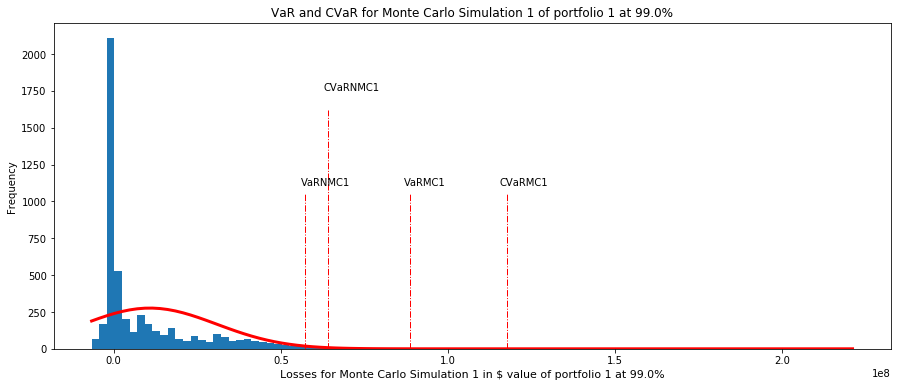

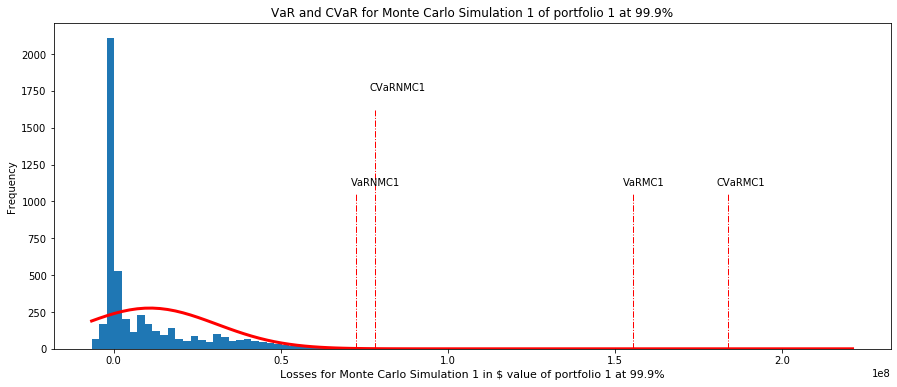

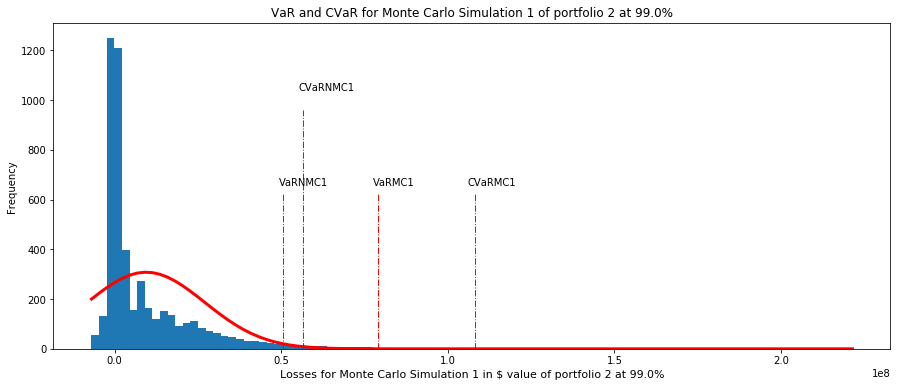

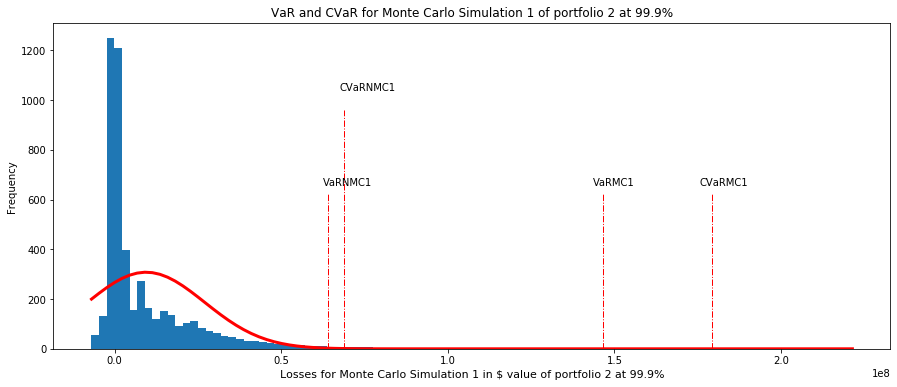

In [13]:
#Plot of VaR and CvaR with respect to portfolio and alphas for MC1
for portN in range(2):
    
    for q in range(alphas.size):
        alf = alphas[q]
        
        plt.figure(figsize = (15,6))
        frequencyCounts, binLocations, patches = plt.hist(portf_loss_MC1[:,portN], 100)
        normf = (1 / (np.std(portf_loss_MC1[:,portN]) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations - np.mean(portf_loss_MC1[:,portN])) / np.std(portf_loss_MC1[:,portN])) ** 2)
        normf = normf * sum(frequencyCounts) / sum(normf)
        plt.plot(binLocations, normf, color='r', linewidth=3.0)
        plt.plot([VaRN1[portN, q], VaRN1[portN, q]], [0, max(frequencyCounts) / 2], color='r', linewidth=1, linestyle='-.')
        plt.plot([VaRMC1[portN, q], VaRMC1[portN, q]], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
        plt.plot([CVaRN1[portN, q], CVaRN1[portN, q]], [0, max(frequencyCounts) / 1.3], color='r', linewidth=1, linestyle='-.')
        plt.plot([CVaRMC1[portN, q], CVaRMC1[portN, q]], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
        plt.text(0.98 * VaRMC1[portN, q], max(frequencyCounts) / 1.9, 'VaRMC1')
        plt.text(0.98 * VaRN1[portN, q], max(frequencyCounts) / 1.9, 'VaRNMC1')
        plt.text(0.98 * CVaRMC1[portN, q], max(frequencyCounts) / 1.9, 'CVaRMC1')
        plt.text(0.98 * CVaRN1[portN, q], max(frequencyCounts) / 1.2, 'CVaRNMC1')
        plt.title('VaR and CVaR for Monte Carlo Simulation 1 of portfolio '+str(portN+1)+' at '+str(100*alf)+'%')
        plt.xlabel('Losses for Monte Carlo Simulation 1 in $ value of portfolio '+str(portN+1)+' at '+str(100*alf)+'%', fontsize = 11)
        plt.ylabel('Frequency')
        plt.show()

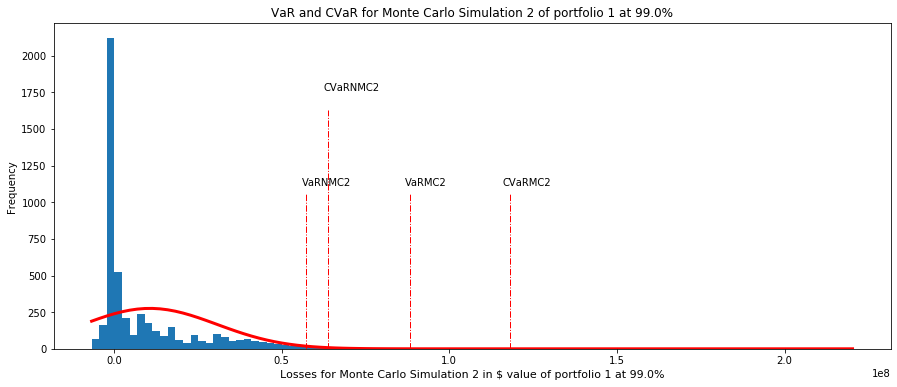

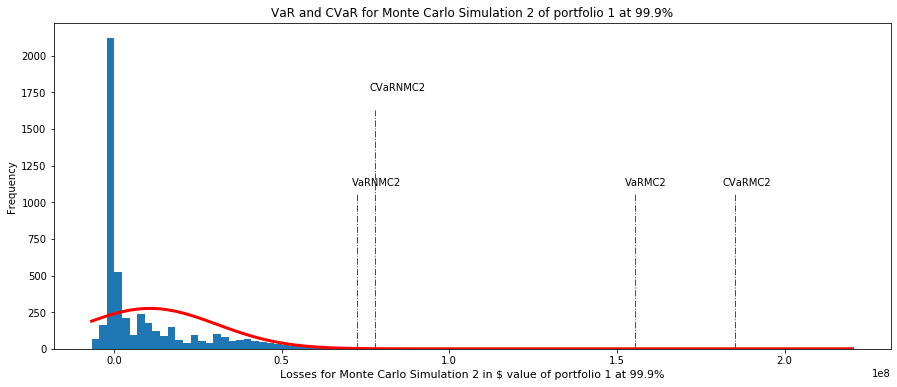

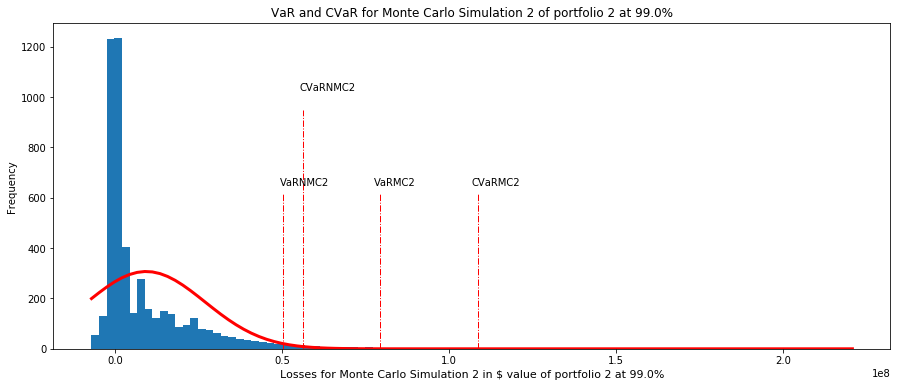

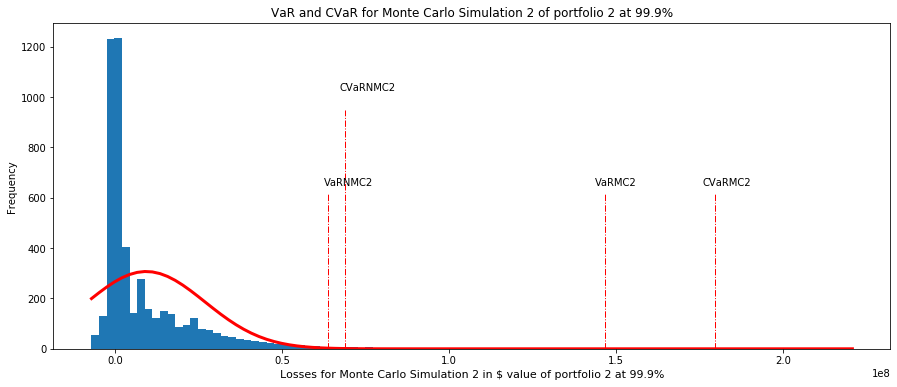

In [14]:
#Plot of VaR and CvaR with respect to portfolio and alphas for MC2
for portN in range(2):
    
    for q in range(alphas.size):
        alf = alphas[q]
        
        plt.figure(figsize = (15,6))
        frequencyCounts, binLocations, patches = plt.hist(portf_loss_MC2[:,portN], 100)
        normf = (1 / (np.std(portf_loss_MC2[:,portN]) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations - np.mean(portf_loss_MC2[:,portN])) / np.std(portf_loss_MC2[:,portN])) ** 2)
        normf = normf * sum(frequencyCounts) / sum(normf)
        plt.plot(binLocations, normf, color='r', linewidth=3.0)
        plt.plot([VaRN2[portN, q], VaRN2[portN, q]], [0, max(frequencyCounts) / 2], color='r', linewidth=1, linestyle='-.')
        plt.plot([VaRMC2[portN, q], VaRMC2[portN, q]], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
        plt.plot([CVaRN2[portN, q], CVaRN2[portN, q]], [0, max(frequencyCounts) / 1.3], color='r', linewidth=1, linestyle='-.')
        plt.plot([CVaRMC2[portN, q], CVaRMC2[portN, q]], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
        plt.text(0.98 * VaRMC2[portN, q], max(frequencyCounts) / 1.9, 'VaRMC2')
        plt.text(0.98 * VaRN2[portN, q], max(frequencyCounts) / 1.9, 'VaRNMC2')
        plt.text(0.98 * CVaRMC2[portN, q], max(frequencyCounts) / 1.9, 'CVaRMC2')
        plt.text(0.98 * CVaRN2[portN, q], max(frequencyCounts) / 1.2, 'CVaRNMC2')
        plt.title('VaR and CVaR for Monte Carlo Simulation 2 of portfolio '+str(portN+1)+' at '+str(100*alf)+'%')
        plt.xlabel('Losses for Monte Carlo Simulation 2 in $ value of portfolio '+str(portN+1)+' at '+str(100*alf)+'%', fontsize = 11)
        plt.ylabel('Frequency')
#         plt.xlim(0, 3e8)
        plt.show()